# 🧠 Brain Tumor MRI Classification Using Deep Learning

## 📘 Introduction

Brain tumors are abnormal growths of tissue in the brain that can be either benign (non-cancerous) or malignant (cancerous). Due to the rigidity of the skull, any abnormal mass can lead to increased intracranial pressure, potentially resulting in brain damage or death. Therefore, **early detection and accurate classification of brain tumors** are critical for improving treatment outcomes and saving lives.

This project aims to leverage **Convolutional Neural Networks (CNNs)** to classify brain MRI scans into four categories:

- **Glioma**
- **Meningioma**
- **Pituitary tumor**
- **No tumor**

By applying deep learning techniques to this medical imaging problem, we contribute to the growing field of AI-assisted diagnosis, providing scalable and accurate diagnostic support to healthcare professionals.

## 🧪 Objective

- Perform **image classification** on brain MRI scans using CNNs
- Accurately distinguish between tumor types and healthy cases
- Explore data preprocessing techniques to improve model accuracy
- Lay the groundwork for future expansion into segmentation or malignancy grading tasks

## 📂 About the Dataset

This project uses a publicly available brain MRI dataset that combines images from the following sources:

- **Figshare**
- **SARTAJ**
- **Br35H**

The dataset consists of **7023 brain MRI images** classified into four categories: `glioma`, `meningioma`, `pituitary`, and `no tumor`. The image sizes vary and require preprocessing and resizing to standard dimensions for CNN input.

> ⚠️ *Note from the dataset author: The glioma class from the SARTAJ dataset was found to be misclassified. These were removed and replaced with correctly labeled images from the Figshare dataset.*

## 🙏 Dataset Credits

Dataset provided by [Masoud Nickparvar](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) on Kaggle.  
If you find this dataset helpful, consider upvoting the original [Kaggle page](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

---

*This notebook is part of a research-inspired project to explore the application of CNNs in brain tumor detection using MRI data.*


In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## 📁 2. Loading and Structuring the Dataset

In this section, we programmatically scan through the dataset directory structure and build a DataFrame that contains the full file paths of all MRI images along with their corresponding set (`Training` or `Testing`) and class labels.

The dataset is organized as follows:

- `archive/`
  - `Training/`
    - `glioma/`
    - `meningioma/`
    - `notumor/`
    - `pituitary/`
  - `Testing/`
    - `glioma/`
    - `meningioma/`
    - `notumor/`
    - `pituitary/`

To prepare the data for analysis and modeling, we:
- Loop through both the `Training` and `Testing` folders.
- Extract the full file paths of images with valid extensions (`.jpg`, `.png`, `.jpeg`).
- Normalize the class labels by converting them to lowercase.
- Store everything in a structured DataFrame with the following columns:
  - `filepaths`: full path to the image file
  - `set`: either `"Training"` or `"Testing"`
  - `class`: one of `"glioma"`, `"meningioma"`, `"notumor"`, or `"pituitary"`

We'll use this DataFrame to perform EDA, visualization, and feed the images into our CNN model later on.


In [4]:
import tensorflow as tf
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

tf.config.list_physical_devices('GPU')


GPU Available: True
GPU Name: Tesla T4


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import os
import pandas as pd

# Step 1: Mount Google Drive


# Step 2: Set the base path to your dataset inside Drive
# Adjust the path below to your actual folder location in Google Drive
base_dir = '/content/drive/My Drive/colab-data/archive'

filepaths = []
sets = []
classes = []

# Step 3: Loop through Training and Testing directories
for split in ['Training', 'Testing']:
    split_path = os.path.join(base_dir, split)

    for class_folder in os.listdir(split_path):
        class_path = os.path.join(split_path, class_folder)

        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(class_path, img_file)
                filepaths.append(full_path)
                sets.append(split)
                classes.append(class_folder.lower().strip())

# Step 4: Create DataFrame
df = pd.DataFrame({
    'filepaths': filepaths,
    'set': sets,
    'class': classes
})

# Step 5: Preview
print(df.head())


                                           filepaths       set   class
0  /content/drive/My Drive/colab-data/archive/Tra...  Training  glioma
1  /content/drive/My Drive/colab-data/archive/Tra...  Training  glioma
2  /content/drive/My Drive/colab-data/archive/Tra...  Training  glioma
3  /content/drive/My Drive/colab-data/archive/Tra...  Training  glioma
4  /content/drive/My Drive/colab-data/archive/Tra...  Training  glioma


In [6]:
# Check number of samples per set
print("Samples per set:")
print(df['set'].value_counts(), "\n")

# Check number of samples per class
print("Samples per class:")
print(df['class'].value_counts(), "\n")

# Check number of samples per class per set
print("Samples per class per set:")
print(df.groupby(['set', 'class']).size())


Samples per set:
set
Training    5712
Testing     1311
Name: count, dtype: int64 

Samples per class:
class
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64 

Samples per class per set:
set       class     
Testing   glioma         300
          meningioma     306
          notumor        405
          pituitary      300
Training  glioma        1321
          meningioma    1339
          notumor       1595
          pituitary     1457
dtype: int64


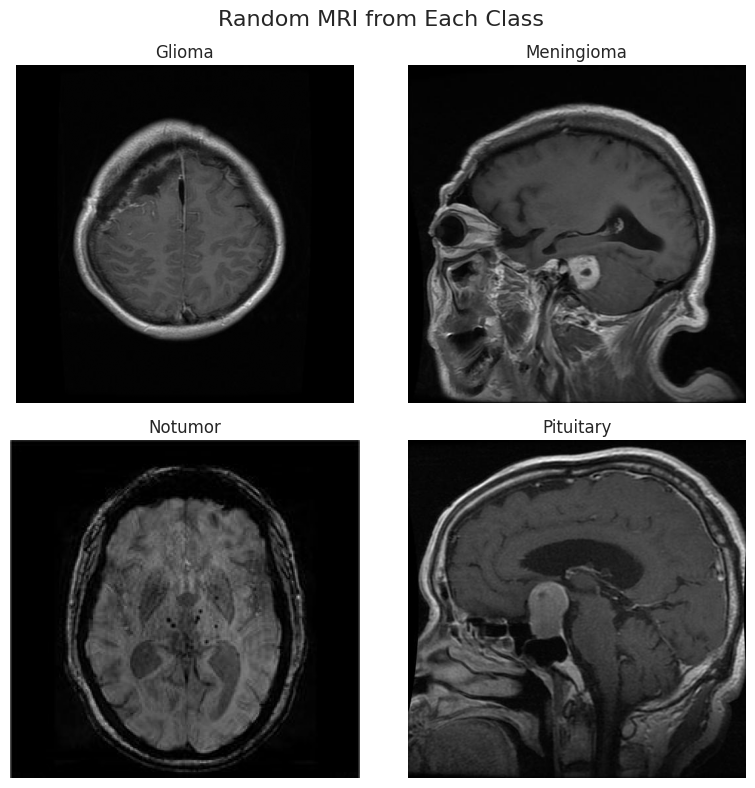

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Sample one random image per class
sample_df = df.groupby('class').apply(lambda x: x.sample(1)).reset_index(drop=True)

# Plot images in a 2x2 grid
plt.figure(figsize=(8, 8))

for i, row in sample_df.iterrows():
    img = Image.open(row['filepaths'])
    plt.subplot(2, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(row['class'].capitalize())
    plt.axis('off')

plt.suptitle("Random MRI from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


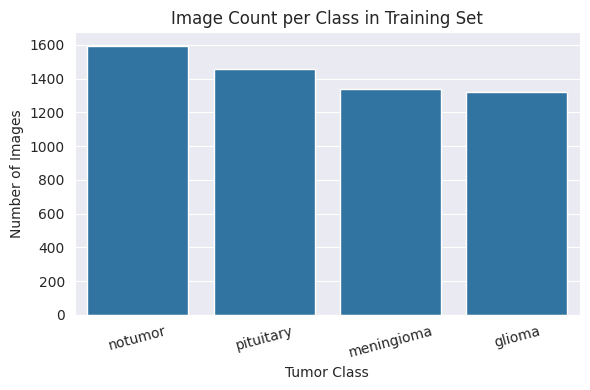

In [8]:
# Filter for training set
train_df = df[df['set'] == 'Training']

# Count class instances
class_counts = train_df['class'].value_counts()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='class', order=class_counts.index)
plt.title("Image Count per Class in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Tumor Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


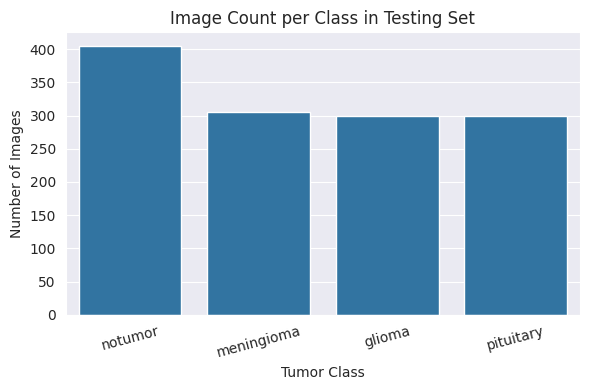

In [9]:
# TEST IMAGES
test_df = df[df['set'] == 'Testing']
test_class_counts = test_df['class'].value_counts()

plt.figure(figsize=(6, 4))
sns.countplot(data=test_df, x='class', order=test_class_counts.index)
plt.title("Image Count per Class in Testing Set")
plt.ylabel("Number of Images")
plt.xlabel("Tumor Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## 🔁 2.2 Cross-Validation Setup (5-Fold Stratified)

To ensure a robust evaluation of our model and avoid relying on a single static validation set, we use **5-fold stratified cross-validation**.

### Why Stratified K-Fold?
- **StratifiedKFold** ensures that **each fold maintains the original class proportions**, so no class is under- or over-represented during training or validation.

### How it Works:
1. We extract only the samples from the `Training` set.
2. We apply `StratifiedKFold` to split the dataset into 5 folds.
3. For each sample, we assign a `fold` number from 0 to 4, indicating which validation fold it belongs to.
4. In each round of training, we can:
   - Use **4 folds for training**
   - Use **1 fold for validation**

This results in **5 different training-validation splits**, and every sample is used as validation exactly once.

### Code Summary:
- `train_df['fold']` column stores the fold assignments.
- Class distribution is checked per fold to ensure stratification.

This approach improves generalization and gives a more reliable estimate of the model’s performance before evaluating on the final test set.


In [10]:
from sklearn.model_selection import train_test_split

# Get only the training data
train_df = df[df['set'] == 'Training'].copy().reset_index(drop=True)

# Split into train and validation sets (e.g., 80/20 split)
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['class'],
    random_state=42
)

print("Train size:", len(train_data))
print("Validation size:", len(val_data))


Train size: 4569
Validation size: 1143


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# General settings
batch_size = 32
img_size = (299, 299)

# Define augmentation and preprocessing generators
train_gen_config = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2)
)

valid_test_gen_config = ImageDataGenerator(
    rescale=1/255
)

def get_generators(train_df, valid_df, test_df, image_size=(299, 299), batch_size=32):
    """
    Returns training, validation, and test generators.

    Parameters:
    - train_df: DataFrame with 'filepaths' and 'class'
    - valid_df: DataFrame with 'filepaths' and 'class'
    - test_df: DataFrame with 'filepaths' and 'class'
    """
    train_gen = train_gen_config.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepaths',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    valid_gen = valid_test_gen_config.flow_from_dataframe(
        dataframe=valid_df,
        x_col='filepaths',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_gen = valid_test_gen_config.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepaths',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, valid_gen, test_gen


Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


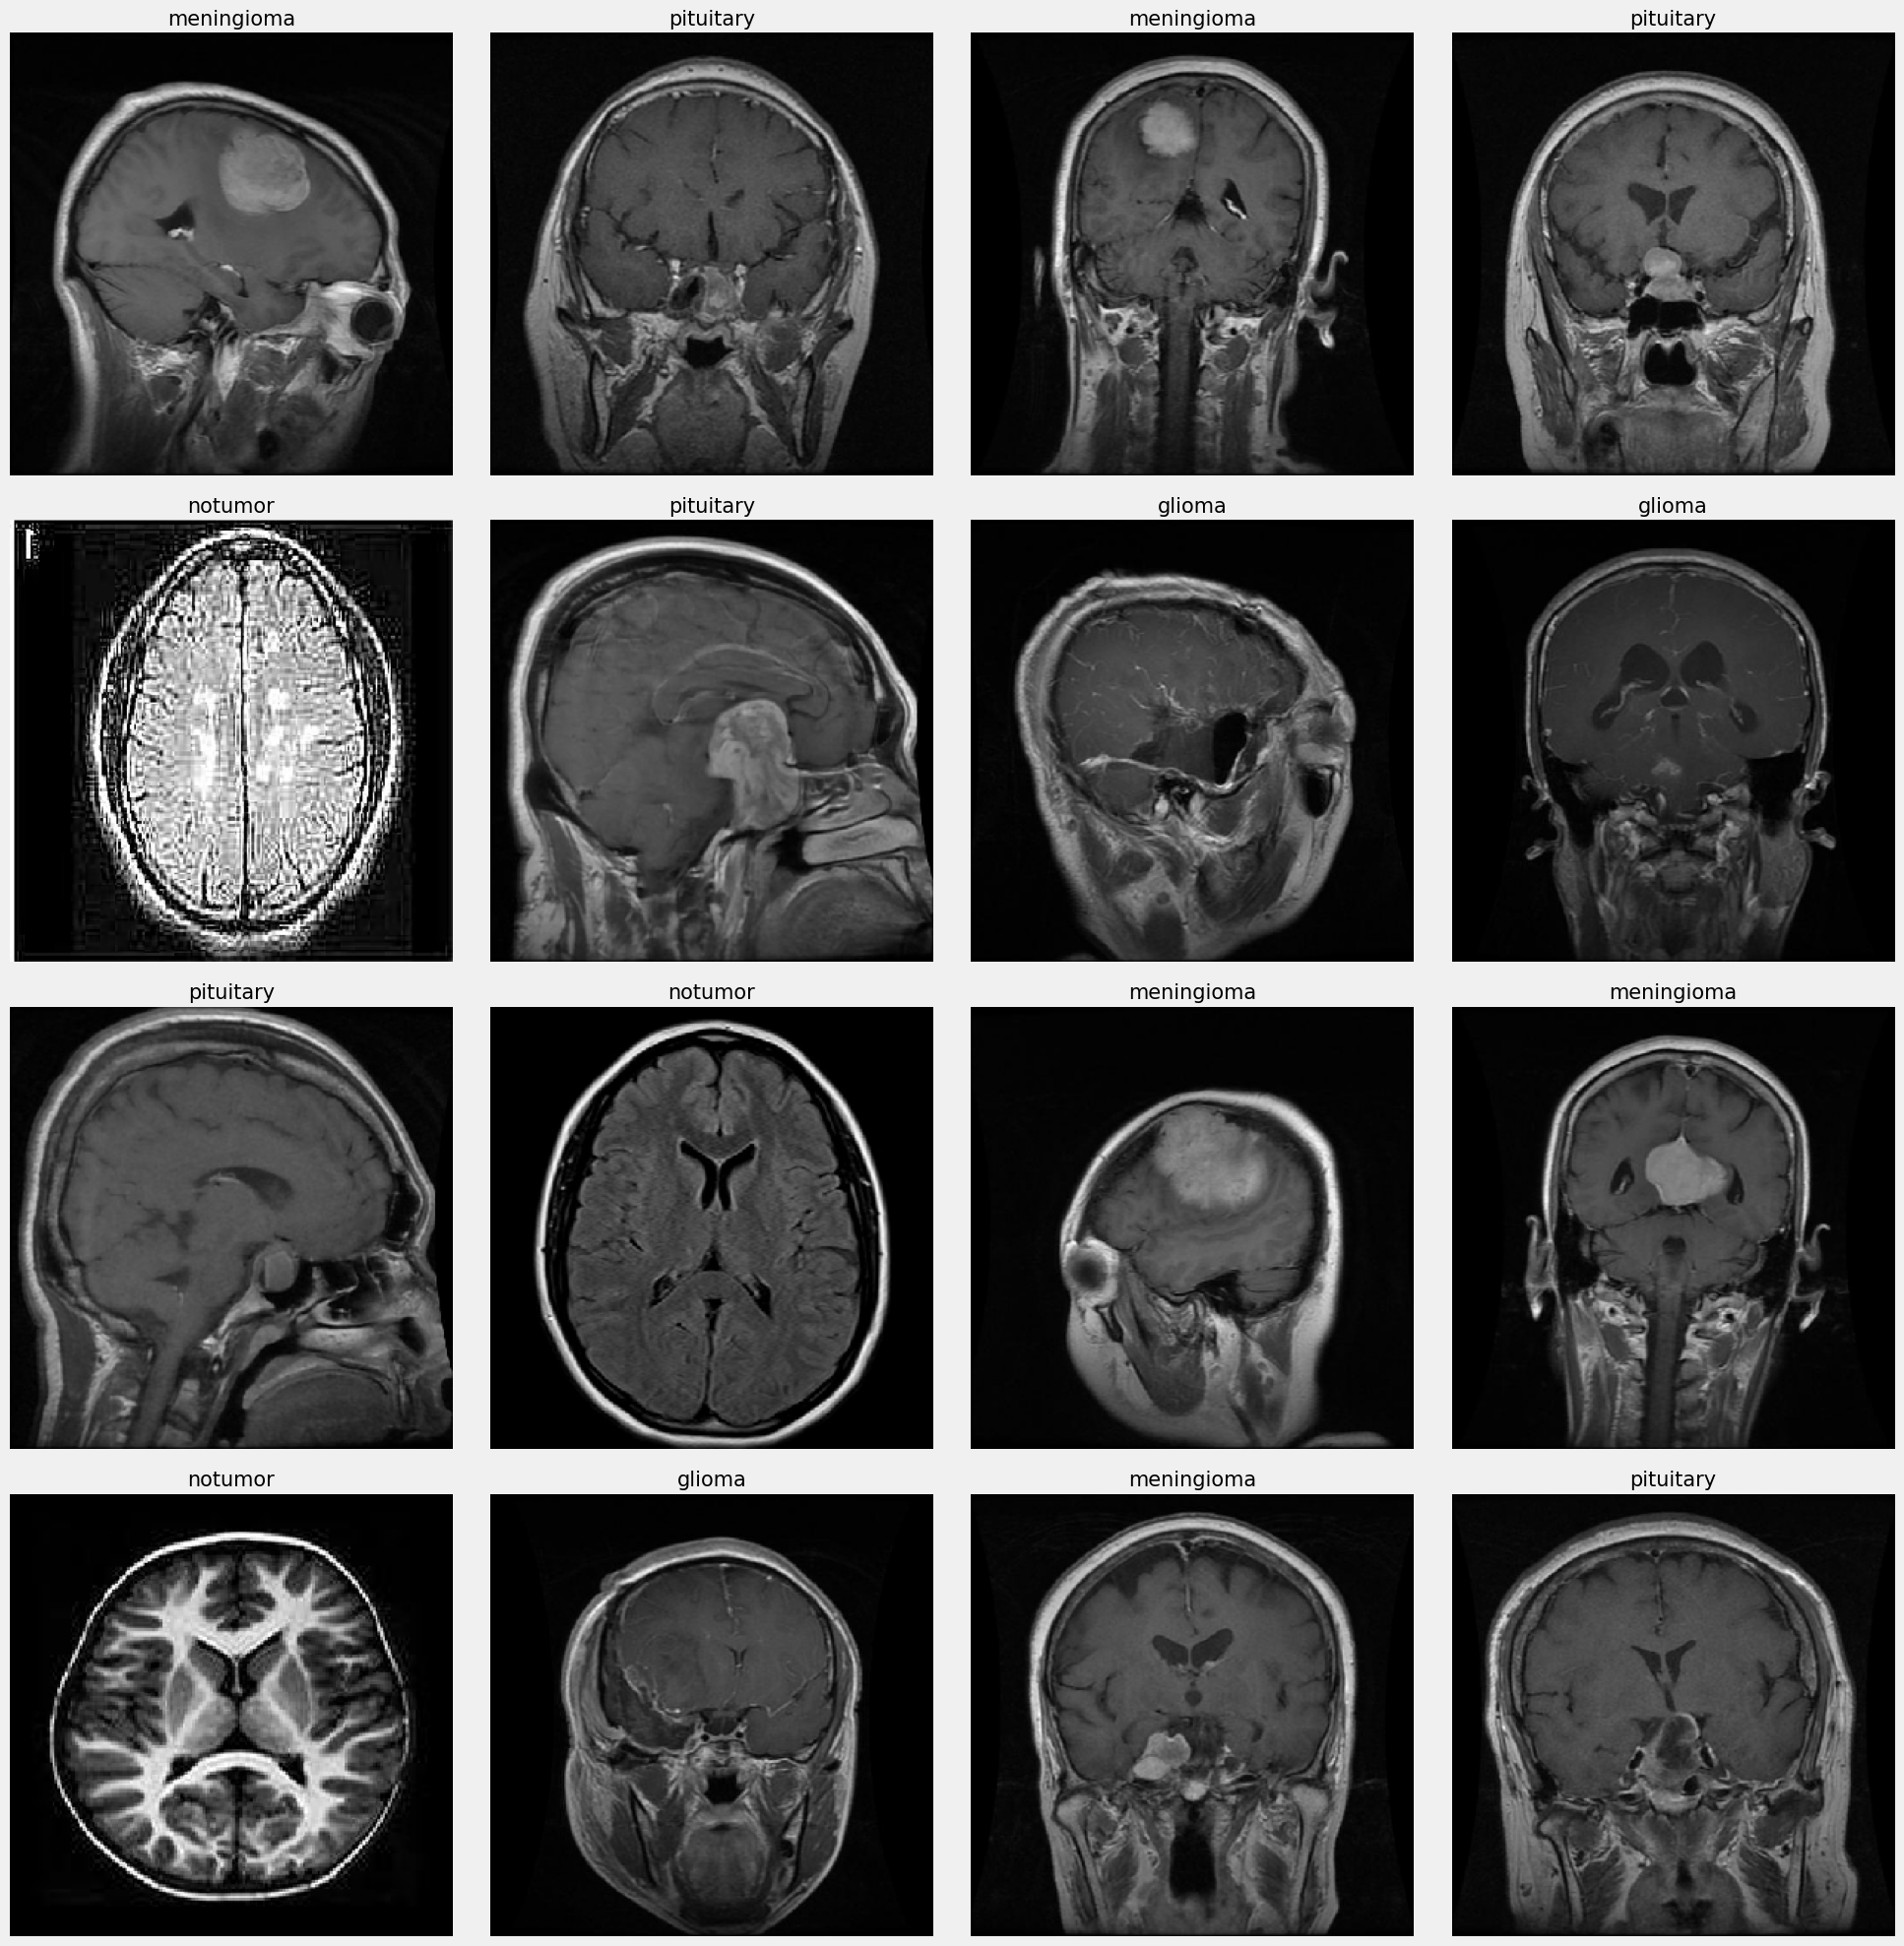

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Use the new generators based on the single train/test split
train_gen, valid_gen, test_gen = get_generators(train_data, val_data, test_df)

# Get class label mapping
class_dict = train_gen.class_indices
classes = list(class_dict.keys())

# Get one batch of images and labels from the validation set
images, labels = next(valid_gen)

# Plot a 4x4 grid of images
plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images[:16], labels[:16])):  # Show 16 images
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import Xception
from tensorflow.keras.metrics import Precision, Recall

def build_model(input_shape=(299, 299, 3), num_classes=4):
    base_model = Xception(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling='max'
    )

    # Optionally freeze the base model for initial training
    # for layer in base_model.layers:
    #     layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dropout(rate=0.3),
        Dense(128, activation='relu'),
        Dropout(rate=0.25),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adamax(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )

    return model


In [18]:
print("\n🟦 Training model on train/validation split")

# Load generators
train_gen, valid_gen = get_generators(train_data, val_data)

# Build the model
model = build_model()

# Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,  # or fewer for testing
    verbose=1
)



🟦 Training model on train/validation split
Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2751s 19s/step - accuracy: 0.7660 - loss: 0.7145 - precision: 0.8207 - recall: 0.6578 - val_accuracy: 0.7725 - val_loss: 0.6057 - val_precision: 0.7903 - val_recall: 0.7585
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9758 - loss: 0.0733 - precision: 0.9774 - recall: 0.9736 - val_accuracy: 0.9528 - val_loss: 0.1842 - val_precision: 0.9527 - val_recall: 0.9519
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9887 - loss: 0.0309 - precision: 0.9887 - recall: 0.9884 - val_accuracy: 0.9633 - val_loss: 0.1178 - val_precision: 0.9665 - val_recall: 0.9606
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9956 - loss: 0.0194 - precision: 0.9956 - recall: 0.9956 - val_accuracy: 0.9668 - val_loss: 0.1356 - val_precision: 0.9676 - val_rec

In [19]:
model.save('brain_tumor_classifier.h5')


In [26]:
model.save('brain_tumor_classifier.keras')


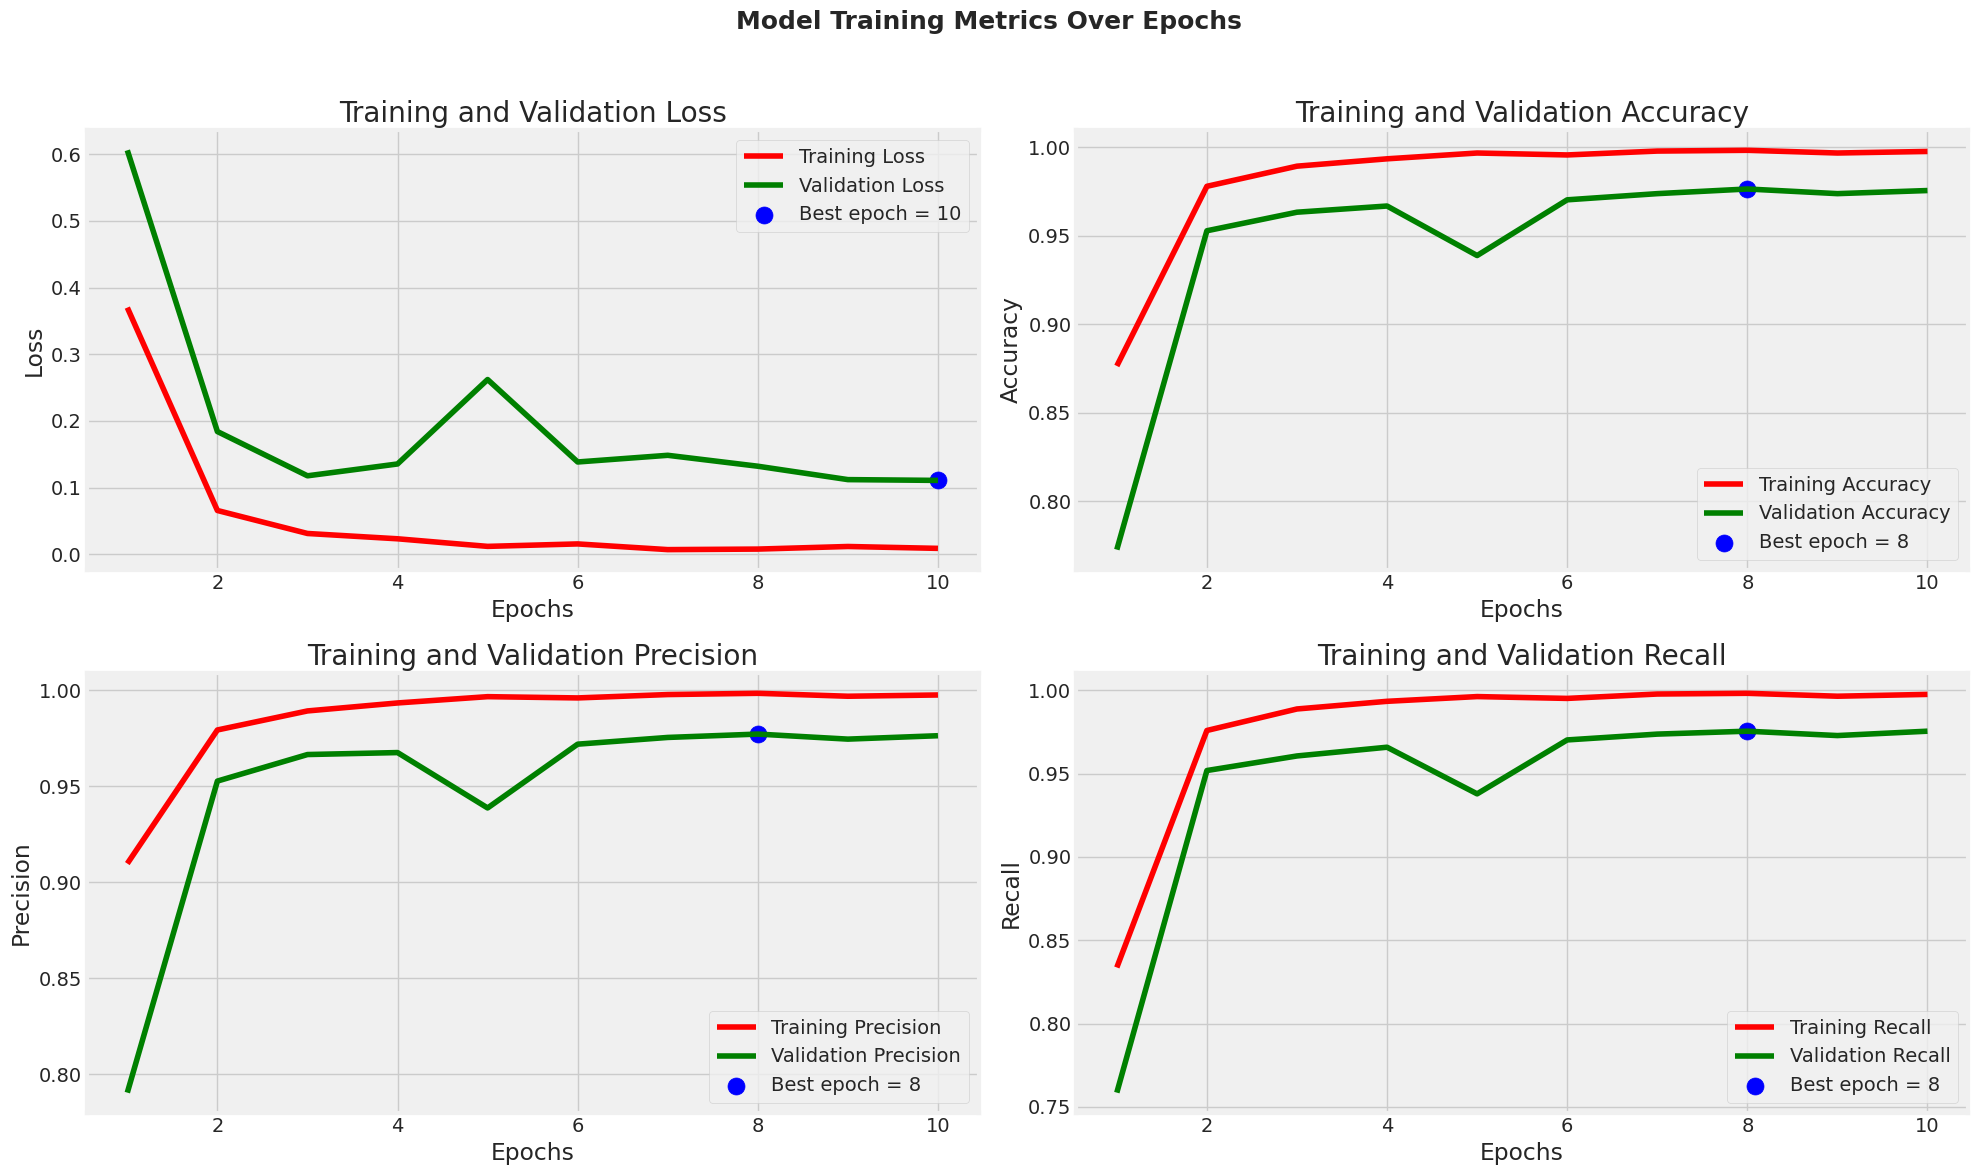

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Replace `hist` with the name of your training history object
hist = history

# Extract training metrics
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']

# Extract validation metrics
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

# Get best metric epochs
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]

index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]

# Annotation labels
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'
per_label = f'Best epoch = {index_precision + 1}'
recall_label = f'Best epoch = {index_recall + 1}'

# Plotting
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Precision plot
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Training Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall plot
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Training Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [33]:
# ✅ Evaluate model performance on all sets
train_loss, train_acc, train_prec, train_recall = model.evaluate(train_gen, verbose=1)
val_loss, val_acc, val_prec, val_recall = model.evaluate(valid_gen, verbose=1)
test_loss, test_acc, test_prec, test_recall = model.evaluate(test_gen, verbose=1)

# 🟦 Train Results
print("🟦 Train Set")
print(f"Loss      : {train_loss:.4f}")
print(f"Accuracy  : {train_acc * 100:.2f}%")
print(f"Precision : {train_prec * 100:.2f}%")
print(f"Recall    : {train_recall * 100:.2f}%")
print('-' * 40)

# 🟨 Validation Results
print("🟨 Validation Set")
print(f"Loss      : {val_loss:.4f}")
print(f"Accuracy  : {val_acc * 100:.2f}%")
print(f"Precision : {val_prec * 100:.2f}%")
print(f"Recall    : {val_recall * 100:.2f}%")
print('-' * 40)

# 🟥 Test Results
print("🟥 Test Set")
print(f"Loss      : {test_loss:.4f}")
print(f"Accuracy  : {test_acc * 100:.2f}%")
print(f"Precision : {test_prec * 100:.2f}%")
print(f"Recall    : {test_recall * 100:.2f}%")


143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 1.0000 - loss: 6.1192e-04 - precision: 1.0000 - recall: 1.0000
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.9731 - loss: 0.1106 - precision: 0.9738 - recall: 0.9731
41/41 ━━━━━━━━━━━━━━━━━━━━ 847s 21s/step - accuracy: 0.9797 - loss: 0.0679 - precision: 0.9808 - recall: 0.9797
🟦 Train Set
Loss      : 0.0005
Accuracy  : 100.00%
Precision : 100.00%
Recall    : 100.00%
----------------------------------------
🟨 Validation Set
Loss      : 0.1110
Accuracy  : 97.55%
Precision : 97.64%
Recall    : 97.55%
----------------------------------------
🟥 Test Set
Loss      : 0.0471
Accuracy  : 98.63%
Precision : 98.70%
Recall    : 98.63%


In [34]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 407ms/step


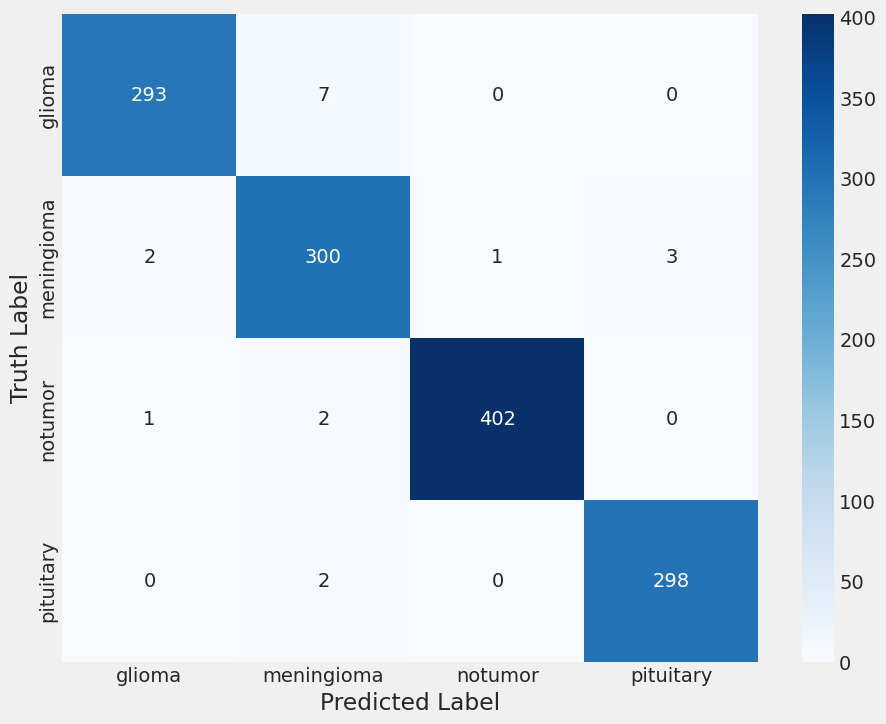

In [36]:
cm = confusion_matrix(test_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [38]:
clr = classification_report(test_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       300
           1       0.96      0.98      0.97       306
           2       1.00      0.99      1.00       405
           3       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [40]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


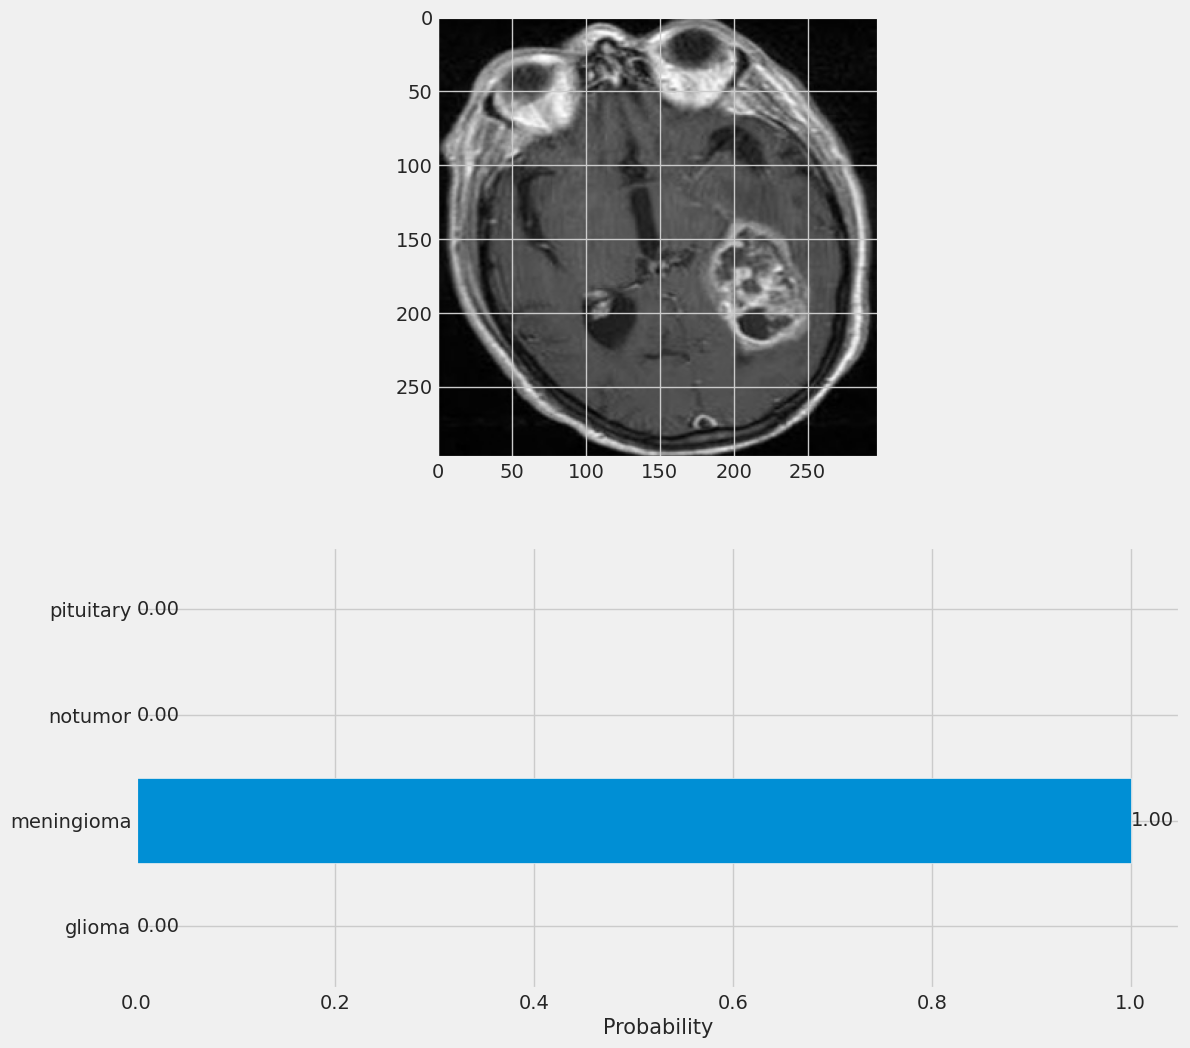

In [44]:
# MENINGIOMA
image_path = "/content/drive/MyDrive/colab-data/archive/Testing/meningioma/Te-meTr_0001.jpg"

predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


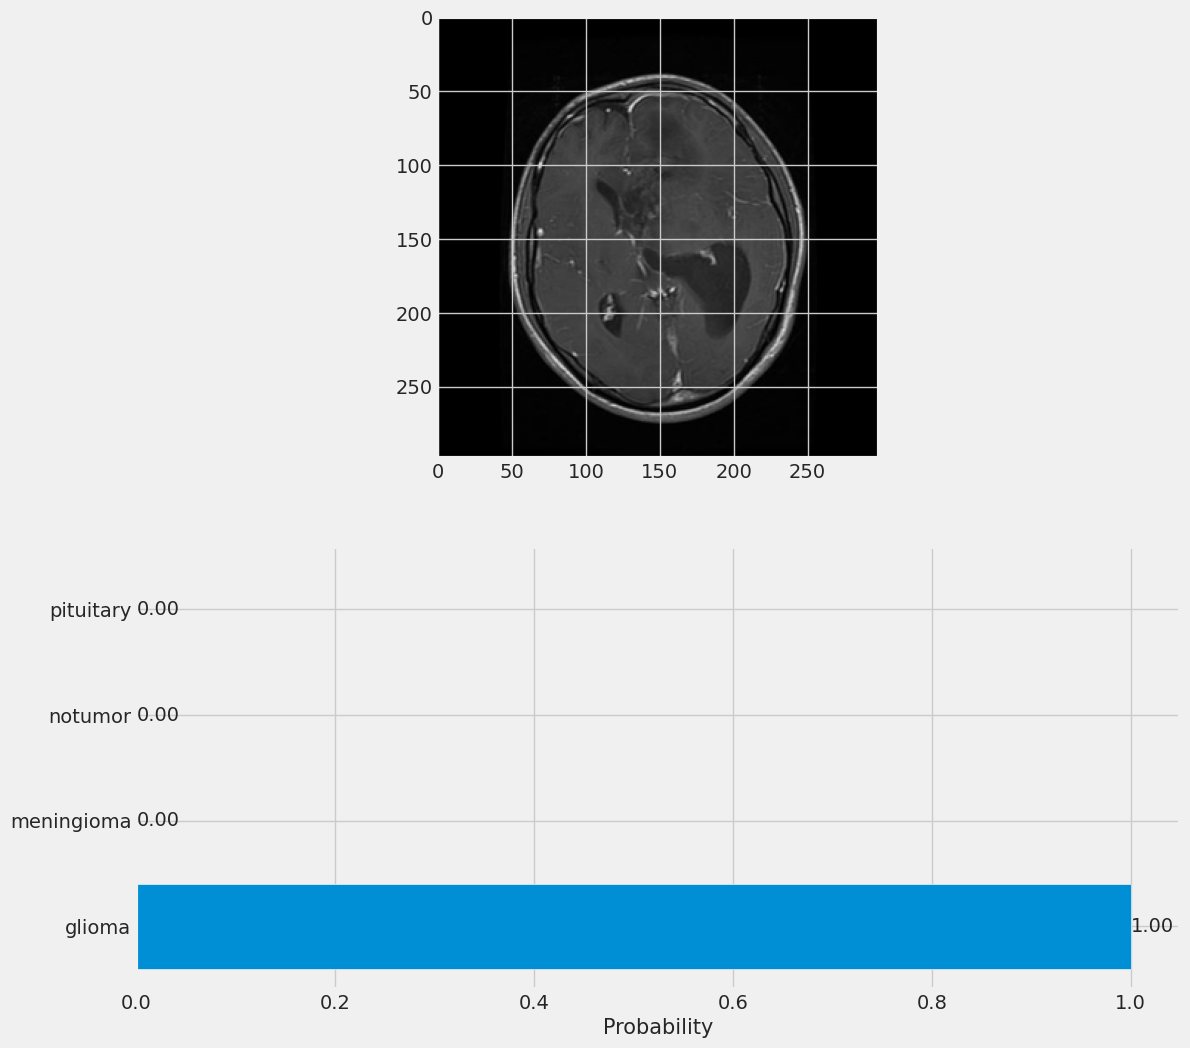

In [51]:
# GLIOMA
image_path = "/content/drive/MyDrive/colab-data/archive/Testing/glioma/Te-glTr_0009.jpg"

predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


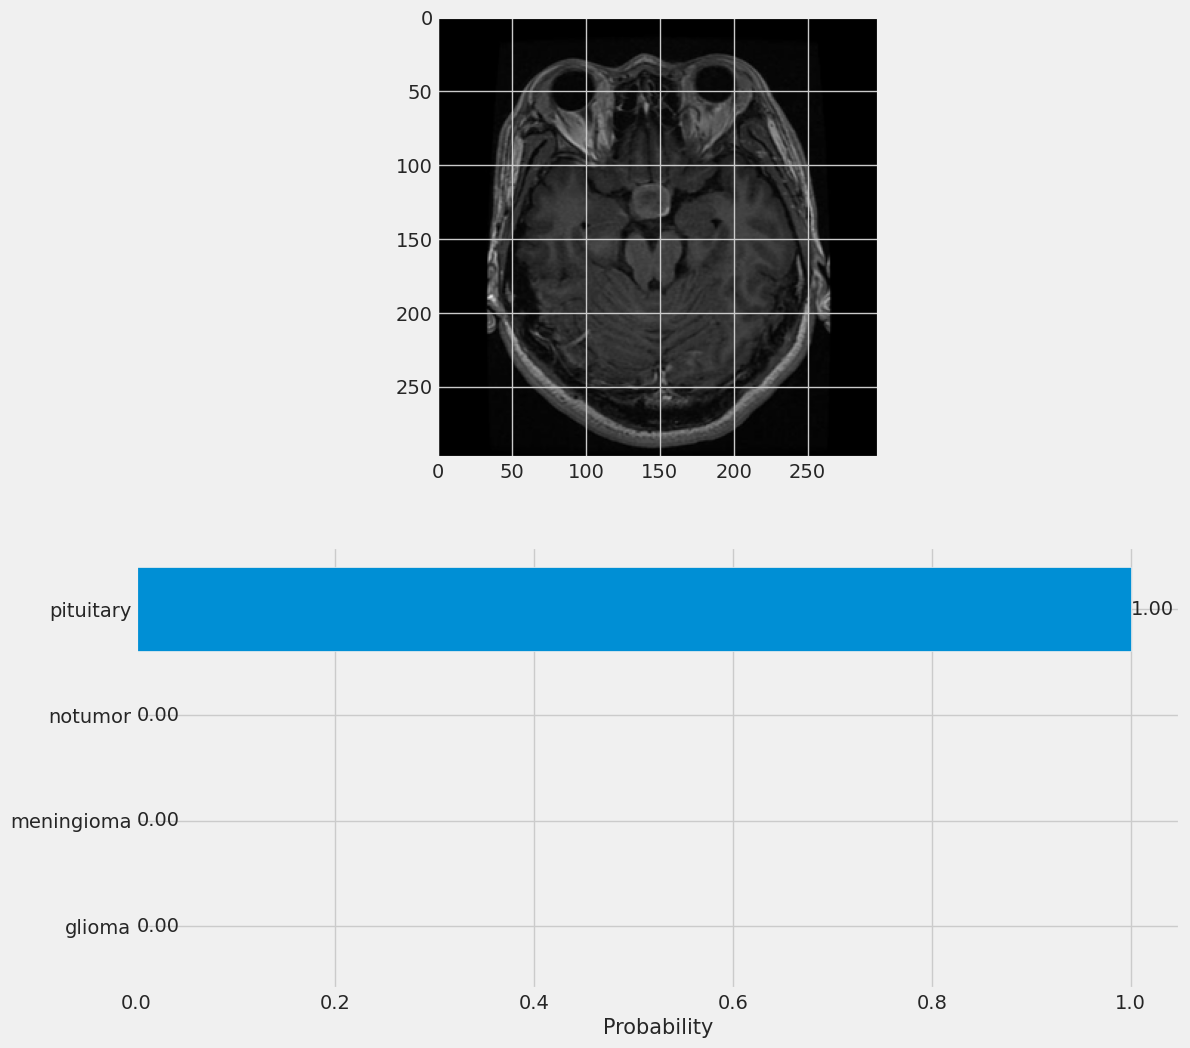

In [52]:
# PITUITARY
image_path = "/content/drive/MyDrive/colab-data/archive/Testing/pituitary/Te-piTr_0009.jpg"

predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


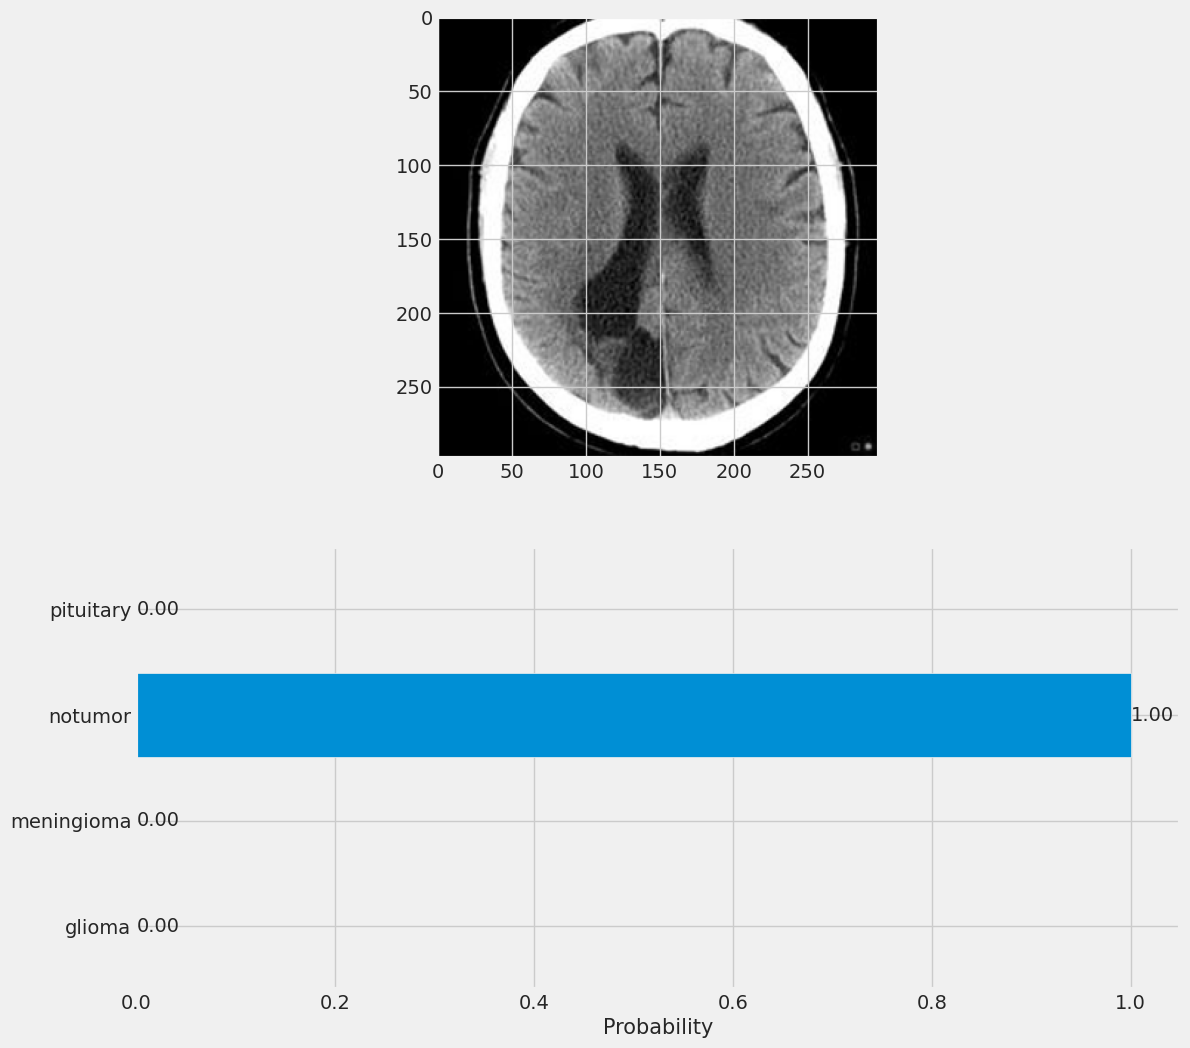

In [55]:
# NO TUMOR
image_path = "/content/drive/MyDrive/colab-data/archive/Testing/notumor/Te-noTr_0009.jpg"

predict(image_path)